# Spectral and pseudo-spectral methods

Note: Some of the code used here is adapted from MATLAB codes in Trefethen's *Spectral Methods in Matlab*.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from JSAnimation import IPython_display # if you don't have this, get it from: https://github.com/jakevdp/JSAnimation

# Advection-diffusion (again)

$$
\newcommand{\F}{\mathcal F}
\newcommand{\Finv}{{\mathcal F}^{-1}}
$$

In notebook 1 we solved the scalar, linear 1D evolution equation:

$$u_t + u_x = \epsilon u_{xx}$$

by taking the Fourier transform, which "diagonalizes" this infinite-dimensional dynamical system:

$$\hat{u}_t + i\xi\hat{u} = -\xi^2 \epsilon \hat{u}$$

with solution:

$$\hat{u}'(t) = e^{(-i \xi - \epsilon \xi^2)t} \hat{u}(0)$$

for each mode.

To construct the full solution, we simply take the inverse Fourier transform.  All together, this algorithm looks like:

$$
u(t) = \Finv \left(D\left[e^{(-i \xi - \epsilon \xi^2)t}\right]\F(u) \right),
$$

where we have written $D[f(\xi)]$ to denote the diagonal matrix whose $(j,j)$ entry is given by $f(\xi_j)$.
In the exact solution, the wavenumbers $\xi$ range from $-\infty$ to $+\infty$ (and $D$ is infinite), but in practice we compute on a finite interval of length $L$ with $m$ collocation points.
The wavenumbers are then given by the formula

\begin{align}
\xi_j & = \frac{2 \pi j}{L} & \text{for } -m/2 \le j < m/2,
\end{align}

although the FFT routine orders them differently.

We can make the algorithm even more explicit by recognizing that the FFT (and its inverse) are just fast ways of multiplying by a certain matrix (and its inverse).  Thus

$$\F(u) = Fu$$

where $F$ is a certain matrix.  This matrix has a number of interesting properties (see e.g. Trefethen, Ch. 3), but for the moment we are only interested in the fact that it is a linear operator.  We can reverse engineer it by applying $\F$ to the columns of the identity matrix:

In [2]:
def F_matrix(m):
    F = np.zeros((m,m),dtype=complex)
    for j in range(m):
        v = np.zeros(m)
        v[j] = 1.
        F[:,j] = np.fft.fft(v)
    return F

print F_matrix(4)

[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  0.-1.j -1.+0.j  0.+1.j]
 [ 1.+0.j -1.+0.j  1.+0.j -1.+0.j]
 [ 1.+0.j  0.+1.j -1.+0.j  0.-1.j]]


Thus we can write our "algorithm" simply as

$$
u(t) = F^{-1} D\left[e^{(-i \xi - \epsilon \xi^2)(t-t_0)}\right] F u(t_0).
$$

Now it is completely clear that we are simply applying a similarity transformation that diagonalizes the dynamics of our system.
We can solve any linear, scalar constant-coefficient 1D evolution equation in similar manner, by simply replacing the argument of $D$.  Note that this algorithm is:

- Exact in time (the only error is due to our initial truncation of the Fourier series by sampling the data at a finite set of points); and
- Unconditionally stable.

Here is the implementation as a reminder.


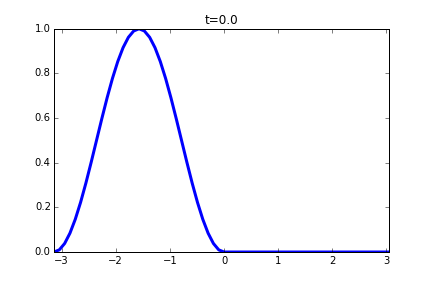
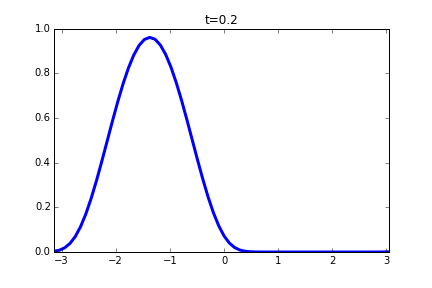
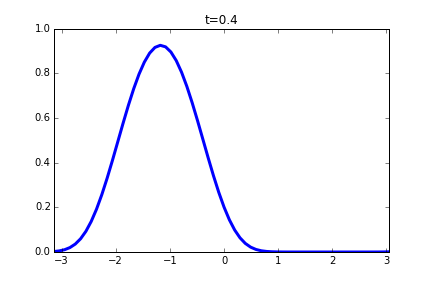
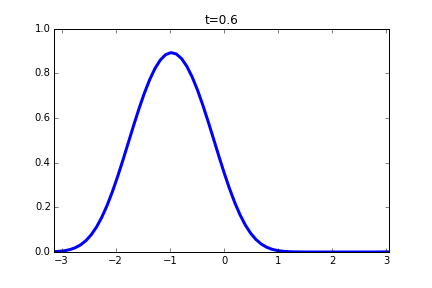
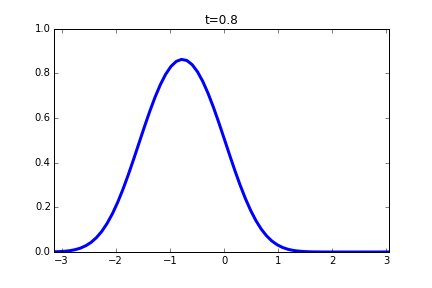
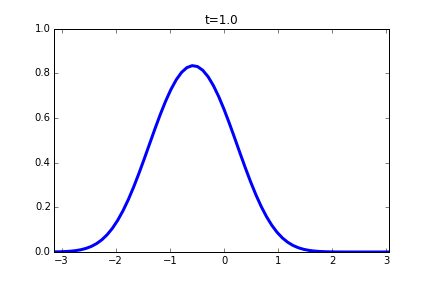
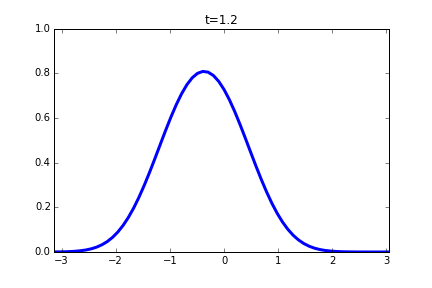
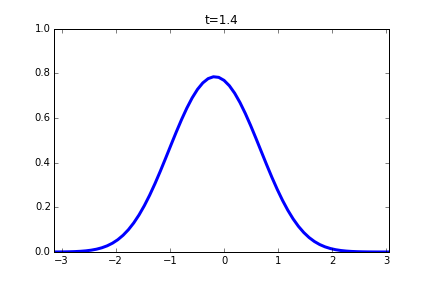
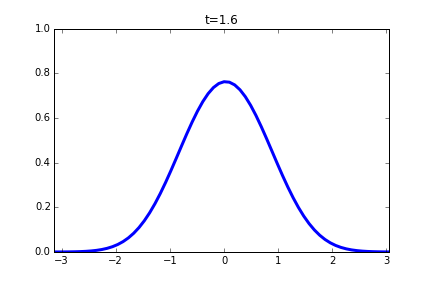
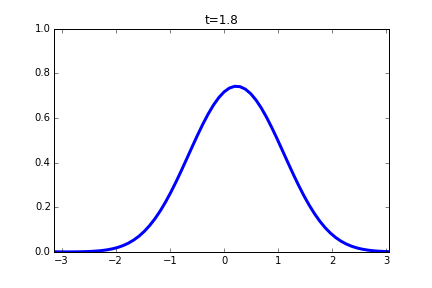
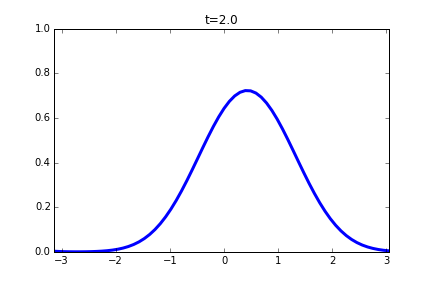

In [3]:
epsilon = 0.1
tmax = 2.0

# Grid
m = 64  # # of points in space
N = 10  # # of times to show output
x = np.arange(-m/2,m/2)*(2*np.pi/m)
dx = x[1]-x[0]
L = x[-1]-x[0] + dx
dt = tmax/N

# Initial data
u = np.sin(x)**2 * (x<0.)

uhat0 = np.fft.fft(u)

# This is the order in which numpy's FFT gives the frequencies:
xi=np.fft.fftfreq(m)*m*2*np.pi/L

# Set up plotting
fig = plt.figure()
axes = fig.add_subplot(111)
line, = axes.plot(x,u,lw=3)
axes.set_xlim((x[0],x[-1]))
axes.set_ylim((0.,1.))

# Store solutions for plotting
frames = [u.copy()]

for n in range(1,N+1):
    t = n*dt
    uhat = np.exp(-(1.j*xi+epsilon*xi**2)*t)*uhat0
    u = np.real(np.fft.ifft(uhat))
    frames.append(u.copy())


def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t='+str(i*dt))

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames), interval=20)

# Variable coefficients

Things become more interesting as soon as we introduce spatially-varying coefficients or nonlinearity.  In either case, the Fourier transform no longer provides a global diagonalization -- instead, it can be thought of as diagonalizing the system at one instant in time.  That means that we will have to discretize in time, and the time step we can use will be restricted by accuracy and (possibly) stability considerations.

Let's start with variable-coefficient advection:

$$ u_t + a(x) u_x = 0.$$

Notice that if we took the Fourier transform of this equation, we would need to compute a convolution of $a(x)$ with $u$, which is computationally quite expensive relative to the rest of what we will do.  To avoid this, we use the "pseudospectral" approach: we compute the derivative $u_x$ in the spectral way and then multiply (in physical space) by $a(x)$.  We have

$$ u_x = \Finv \left(D\left[i\xi\right] F(u)\right).$$

The code below computes the spatial derivative.

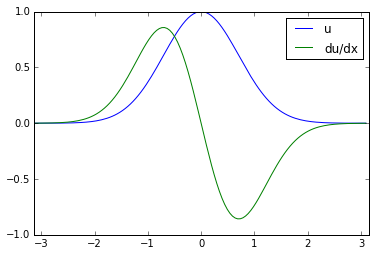

In [4]:
# Grid
m = 128
x = np.arange(-m/2,m/2)*(2*np.pi/m)
dx = x[1]-x[0]
L = x[-1]-x[0] + dx

# Initial data
u = np.exp(-1*(x)**2)
uhat = np.fft.fft(u)

# This is the order in which numpy's FFT gives the frequencies:
xi=np.fft.fftfreq(m)*m*2*np.pi/L

ux = np.real(np.fft.ifft(1j*xi*uhat))
plt.plot(x,u)
plt.hold(True)
plt.plot(x,ux)
plt.xlim(-np.pi,np.pi);
plt.legend(['u','du/dx'])

So we have a semi-discrete system:

$$
U'(t) = -a(x) \Finv \left(D\left[i\xi\right] \F(U)\right).
$$

Next we need to integrate in time.  To choose an appropriate time integrator, we would like to know the spectrum of our semi-discretization.  We can compute it explicitly.

In [5]:
F = F_matrix(m)
Finv = np.linalg.inv(F)
xi=np.fft.fftfreq(m)*m*2*np.pi/L
D = np.diag(1j*xi)
rhs_matrix = np.dot(Finv,np.dot(D,F))

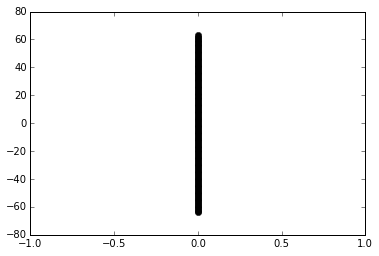

In [6]:
lamda = np.linalg.eigvals(rhs_matrix)
plt.plot(np.real(lamda),np.imag(lamda),'ok')
plt.xlim(-1,1);

What are these eigenvalues?  In fact, they are just the entries of $D[i\xi]$:

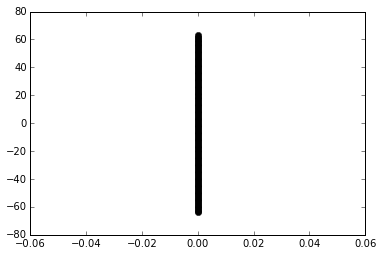

In [7]:
plt.plot(0*xi,xi,'ok')

Indeed, we should have known this already since we are performing a similarity transformation on $D$.

Given these eigenvalues, the Leapfrog method seems an appropriate choice for time integration. (why?)
Thus our full discretization takes the form

$$
U^{n+1} = U^{n-1} -2\Delta t a(x) \Finv \left(D\left[i\xi\right] \F(U)\right).
$$

**What should be the time step restriction for stability for this discretization?**

Check your answer by varying the time step below.  Can you explain what you see?


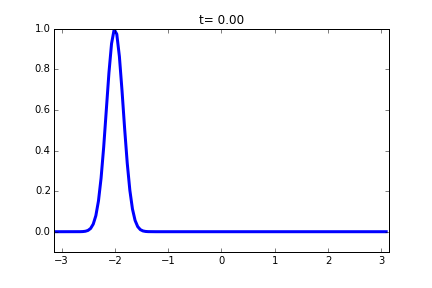
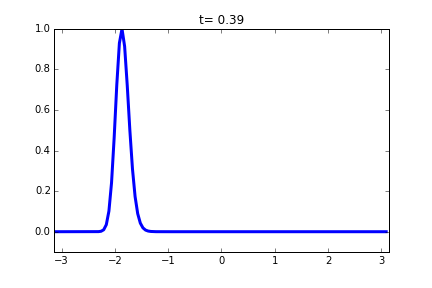
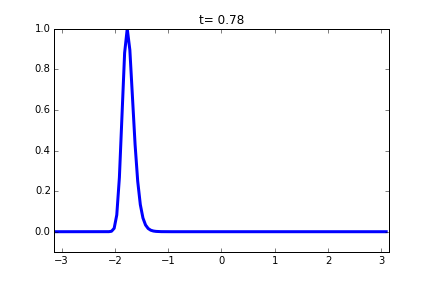
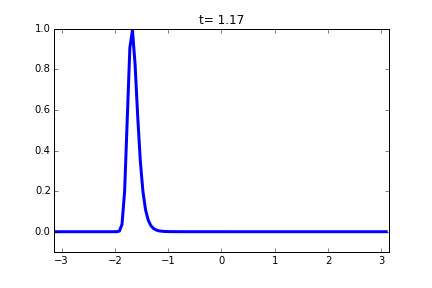
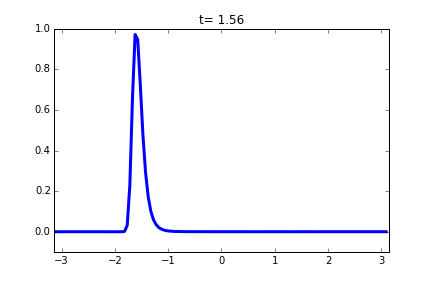
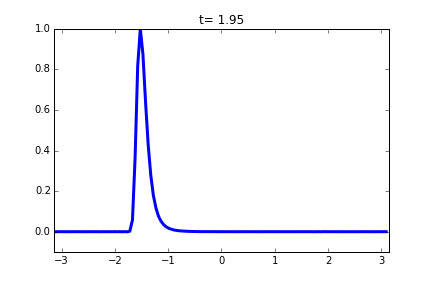
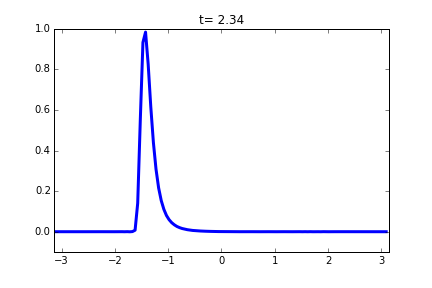
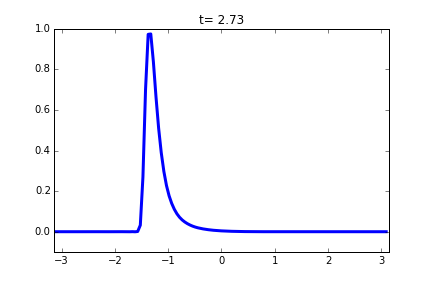
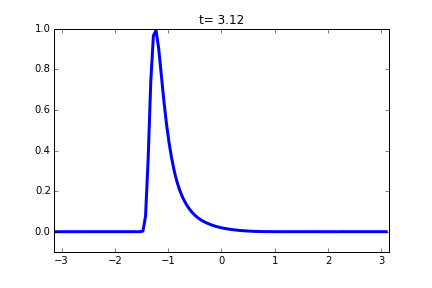
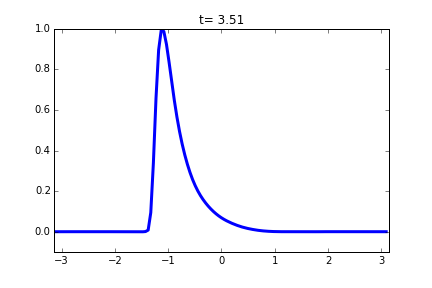
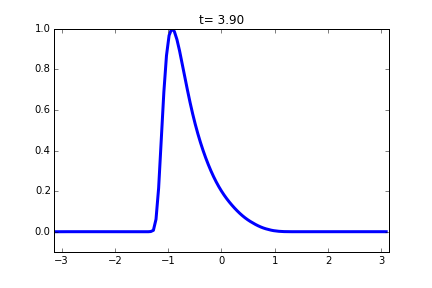
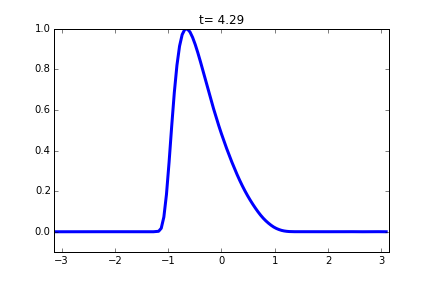
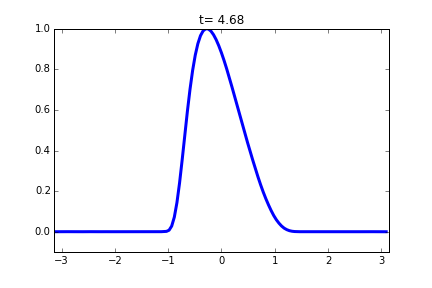
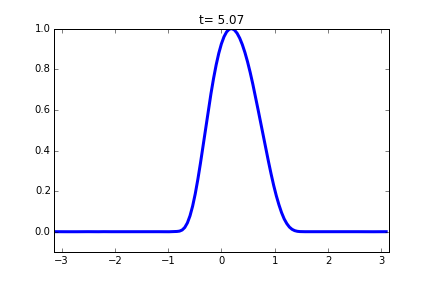
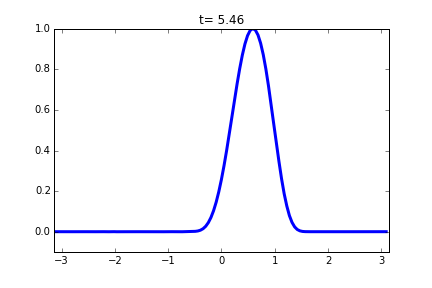
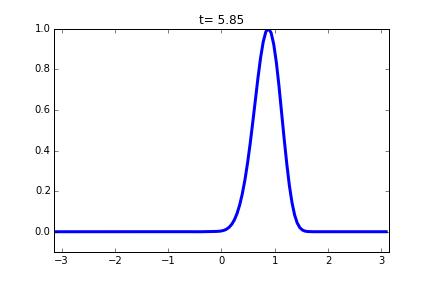
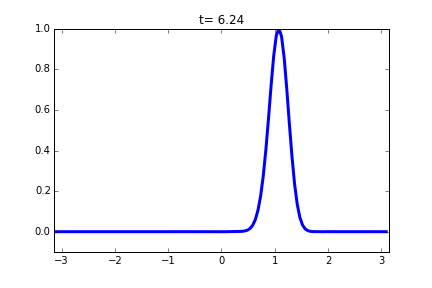
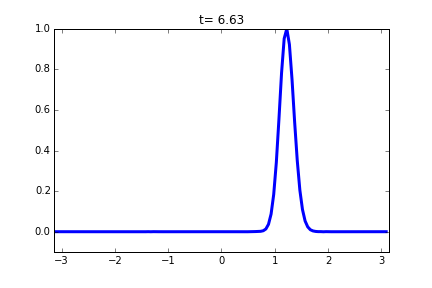
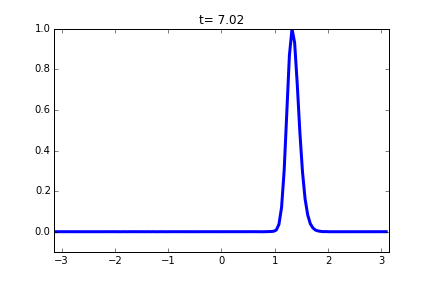
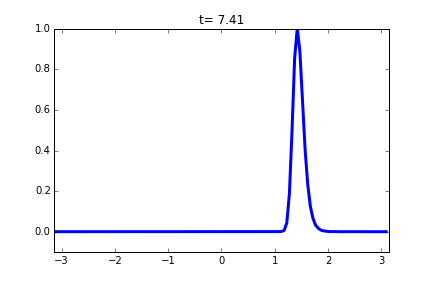
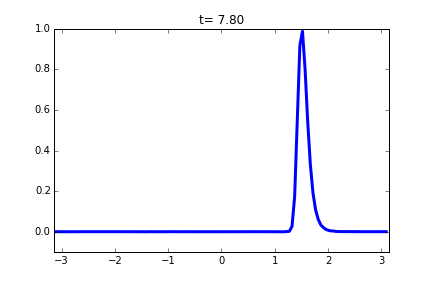
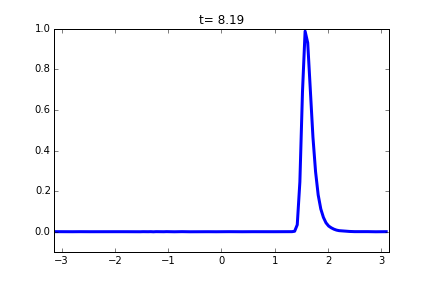
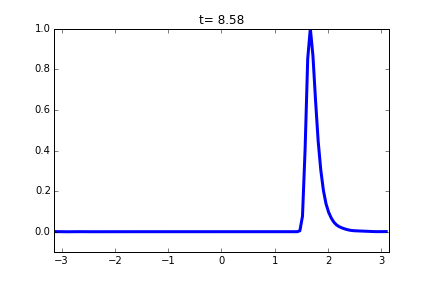
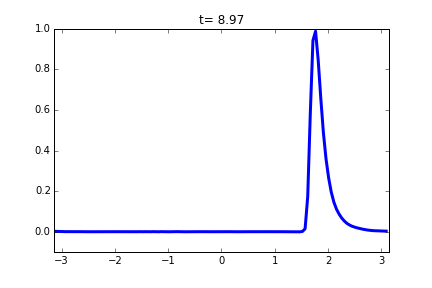
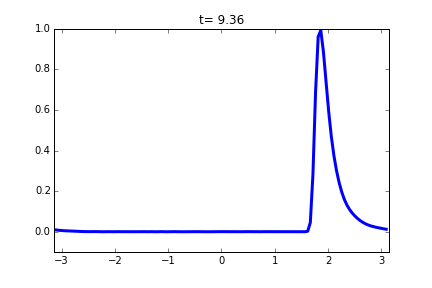
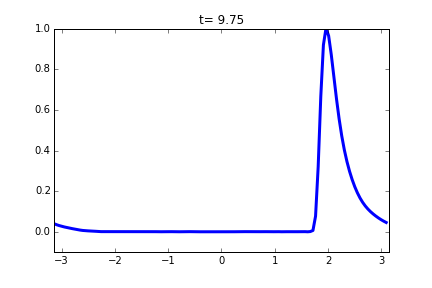
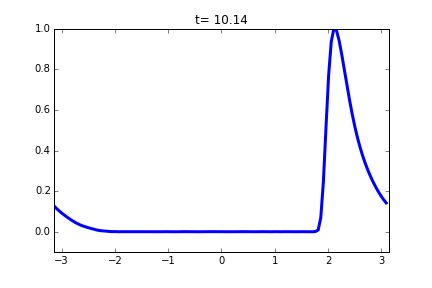
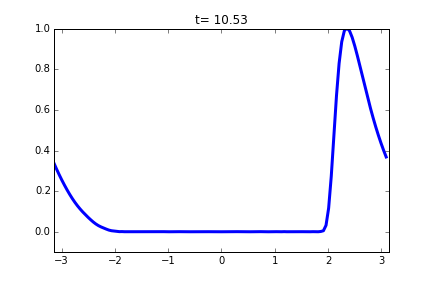
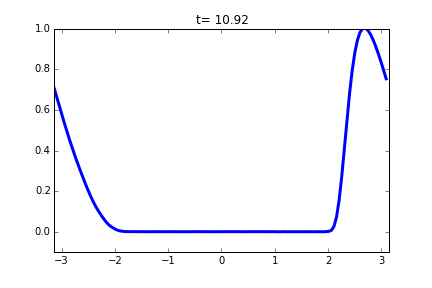
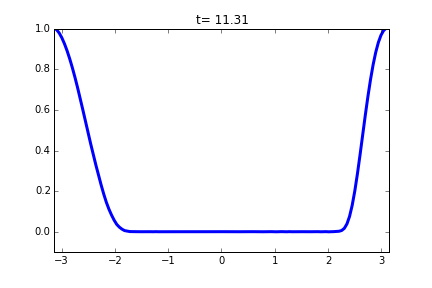
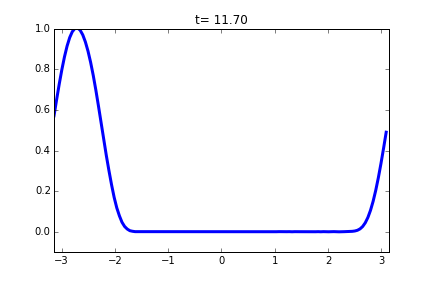
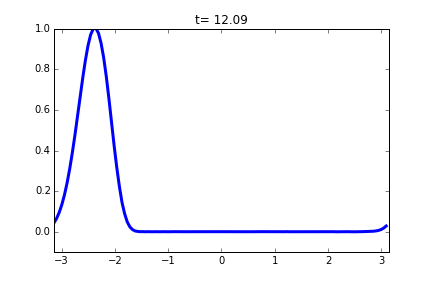
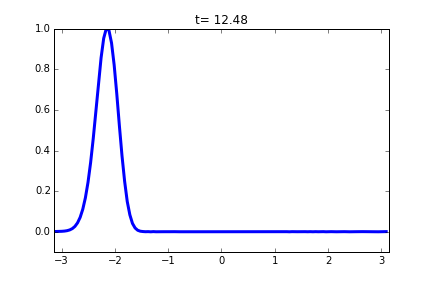
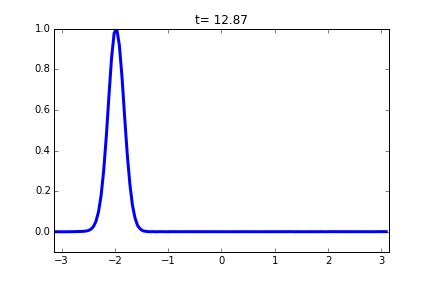
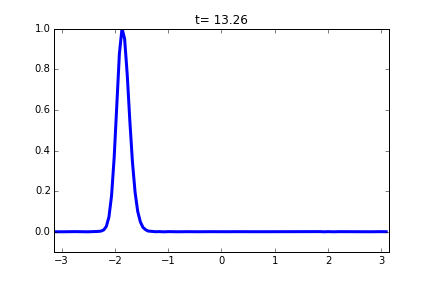
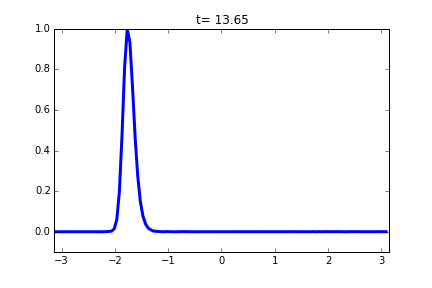
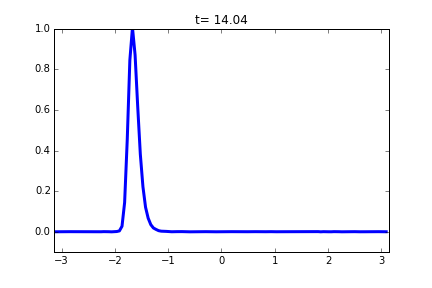
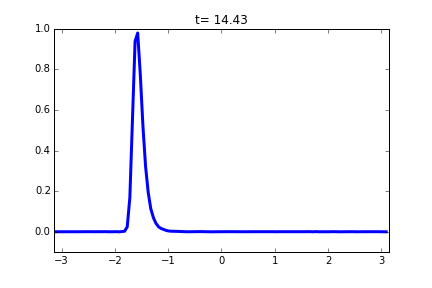
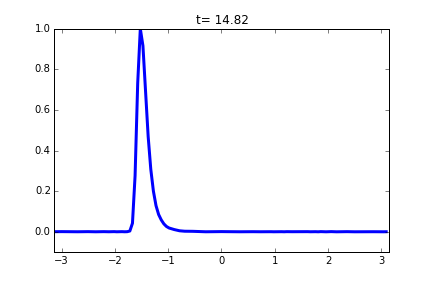
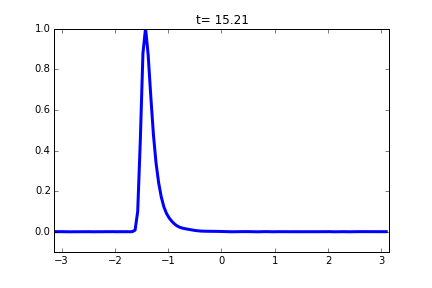
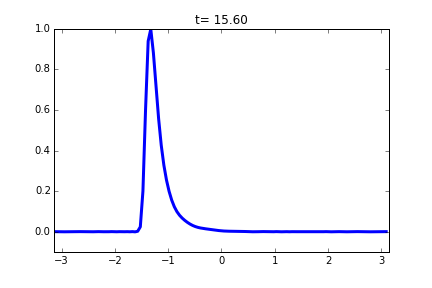
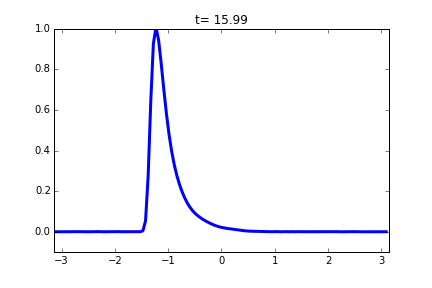
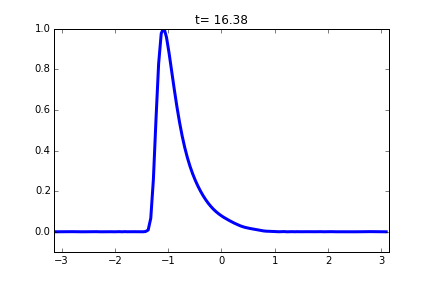
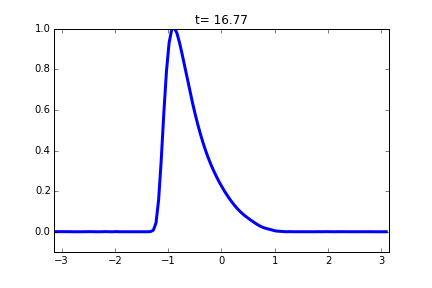
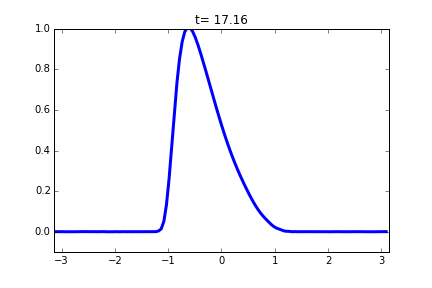
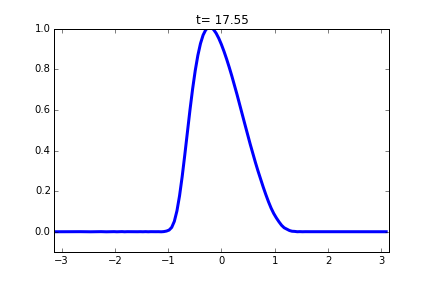
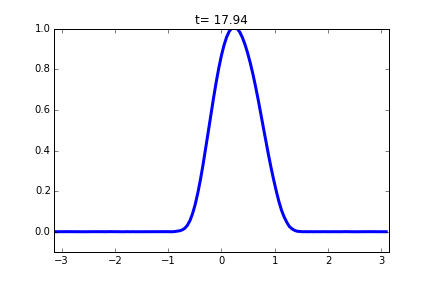
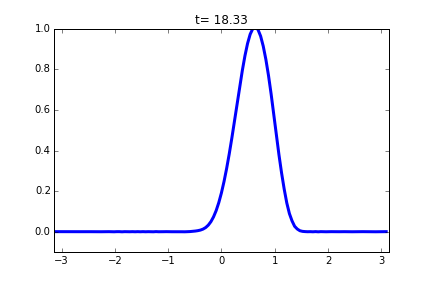
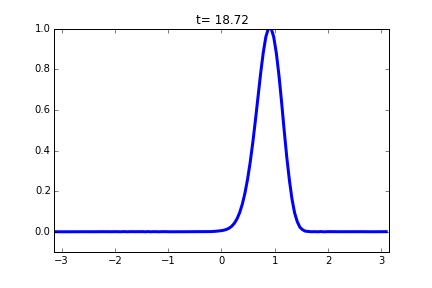
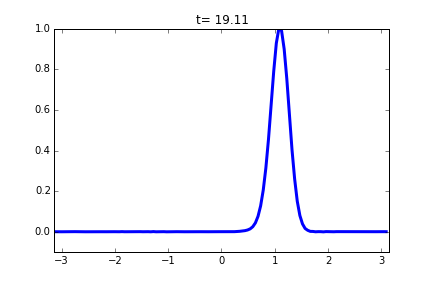
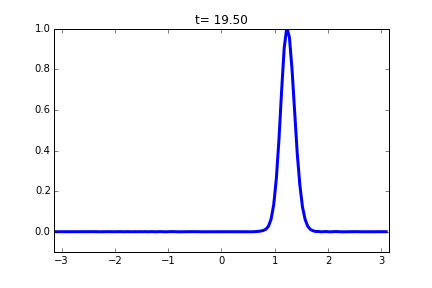
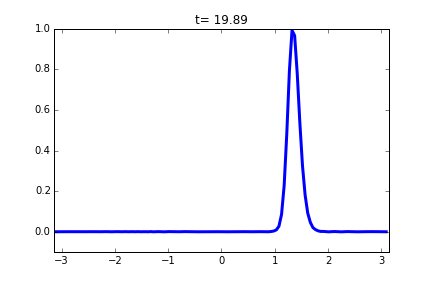

In [8]:
# Grid
m = 128
x = np.arange(-m/2,m/2)*(2*np.pi/m)
dx = x[1]-x[0]
L = x[-1]-x[0] + dx
a = 0.2 + (np.cos(x))**2

k = 0.013
tmax = 20.

# Initial data
u = np.exp(-20*(x+2)**2)
#u_old = np.exp(-10*(x+2+0.2*k)**2)

# This is the order in which numpy's FFT gives the frequencies:
xi=np.fft.fftfreq(m)*m*2*np.pi/L


num_plots = 50
nplt = np.floor((tmax/num_plots)/k)
nmax = int(round(tmax/k))

fig = plt.figure()
axes = fig.add_subplot(111)
line, = axes.plot(x,u,lw=3)

frames = [u.copy()]
tt = [0]

# Take one Runge-Kutta step (3rd-order RK method)
y2 = u - k*a*np.real(np.fft.ifft(1j*xi*np.fft.fft(u)))
y3 = 0.75*u + 0.25*(y2 - k*a*np.real(np.fft.ifft(1j*xi*np.fft.fft(y2))))
u_new = 1./3 * u + 2./3 * (y3 - k*a*np.real(np.fft.ifft(1j*xi*np.fft.fft(y3))))

u_old = u.copy()
u = u_new.copy()

for n in range(1,nmax+1):
    u_x = np.real(np.fft.ifft(1j*xi*np.fft.fft(u)))
    u_new = u_old - 2* k * a * u_x
    
    u_old = u.copy()
    u = u_new.copy()
    t = n*k
    # Plotting
    if np.mod(n,nplt) == 0:
        frames.append(u.copy())
        tt.append(t)
        
def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t= %.2f' % tt[i])
    axes.set_xlim((-np.pi,np.pi))
    axes.set_ylim((-0.1,1.))
    
matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames), interval=20)

# Burgers' equation

Last time, we used an integrating factor.  This time, let's just try the obvious generalization of our variable-coefficient advection discretization.  Writing the equation in the form

$$u_t = - uu_x + \epsilon u_{xx}$$

leads to the pseudospectral semi-discretization

\begin{align}
    U'(t) & = - U \Finv \left(D\left[i\xi\right] \F(U)\right) + \epsilon \Finv \left(D\left[-\xi^2\right] \F(U)\right) \\
          & = \left(-U\Finv D\left[i\xi\right] + \epsilon \Finv D\left[-\xi^2\right] \right) \F U.
\end{align}
The second line is obtained due to linearity of the Fourier transform, and is preferable for implementation since it involves only two rather than three) FFTs per step.

We need to choose a time integrator for this problem.  The eigenvalues of the RHS will depend on U and $\epsilon$, but we can get an idea by choosing some particular U and $\epsilon$:

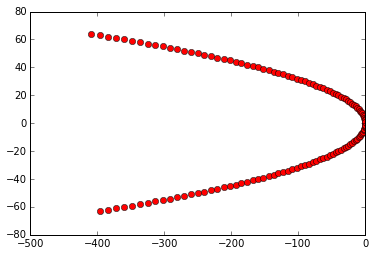

In [9]:
m = 128
x = np.arange(-m/2,m/2)*(2*np.pi/m)
u = np.exp(-20*(x+2)**2)
epsilon = 0.1
u = u/u

F = F_matrix(m)
Finv = np.linalg.inv(F)
xi=np.fft.fftfreq(m)*m*2*np.pi/L
D1 = np.diag(1j*xi)
D2 = np.dot(D1,D1)
rhs_matrix = np.dot(-np.diag(u),np.dot(Finv,np.dot(D1,F))) + epsilon*np.dot(Finv,np.dot(D2,F))

lamda = np.linalg.eigvals(rhs_matrix)
plt.plot(np.real(lamda),np.imag(lamda),'or')

(-500.0, 0.0, -80.0, 80.0)

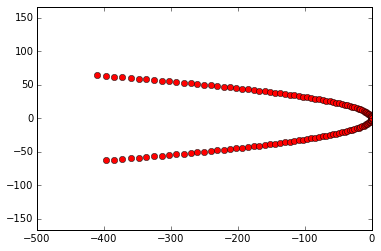

In [10]:
plt.plot(np.real(lamda),np.imag(lamda),'or')
plt.axis('equal')

Two things are immediately clear:

1. We should not use the midpoint method, since the eigenvalues of this semi-discretization have large real part.
2. More importantly, if we use any explicit method then we will need to take very small time steps, due to the large negative real components.

Try changing $m$ and notice how the real and imaginary parts of the spectrum scale.  This can also be deduced from looking at the semi-discretization, or noticing that the spectrum is approximately a parabola.


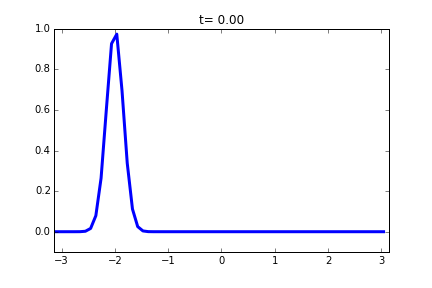
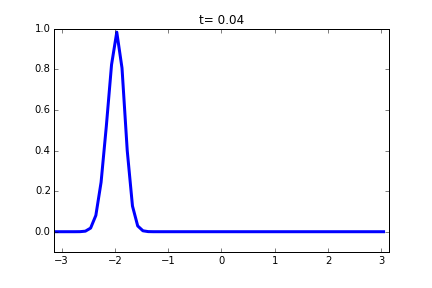
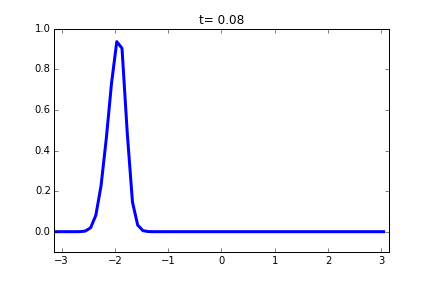
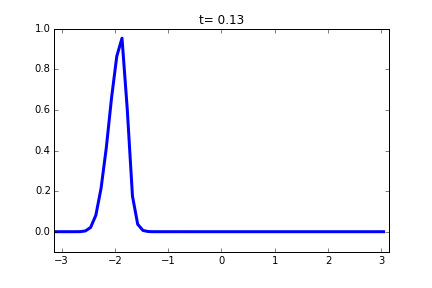
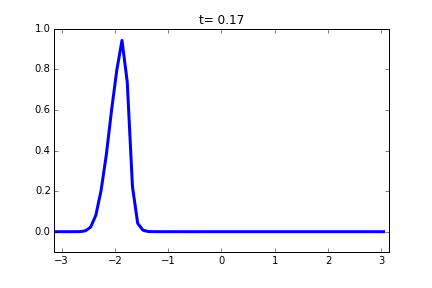
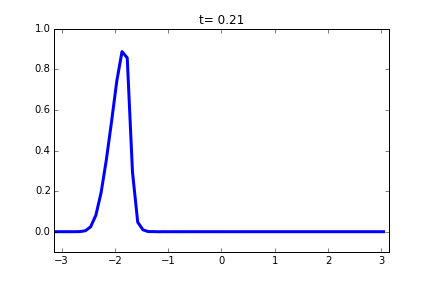
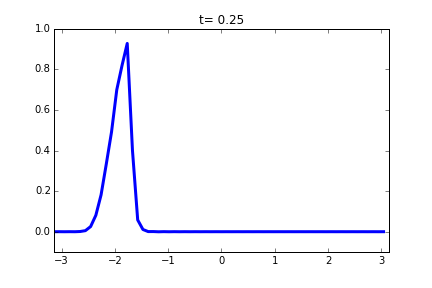
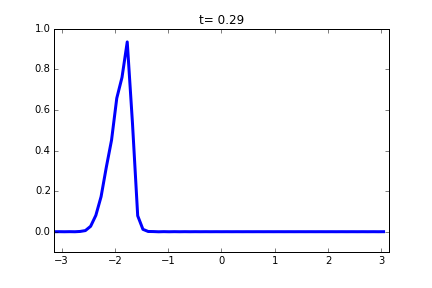
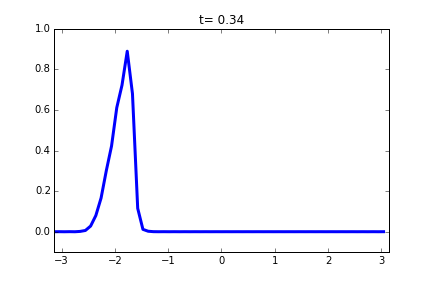
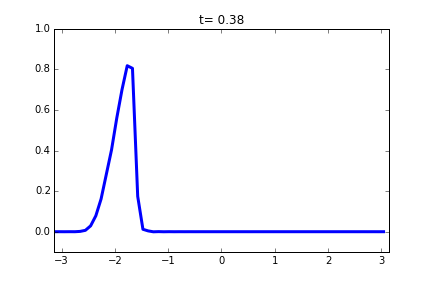
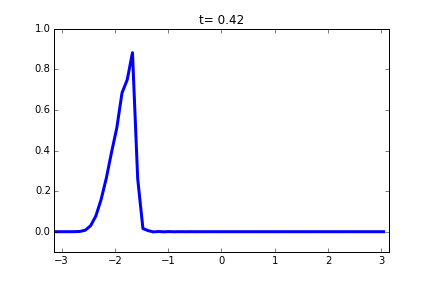
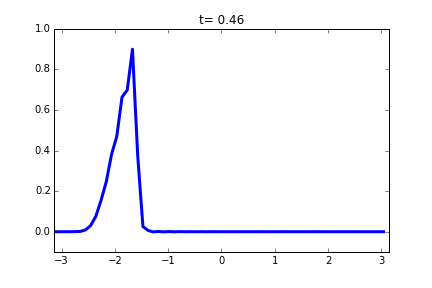
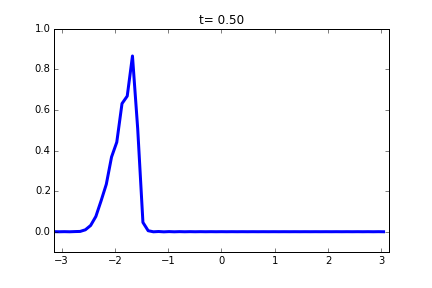
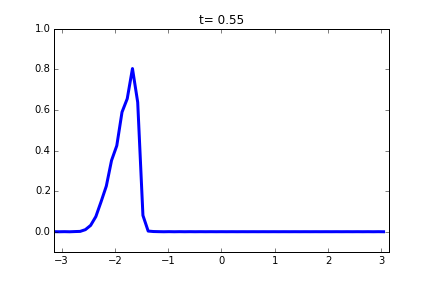
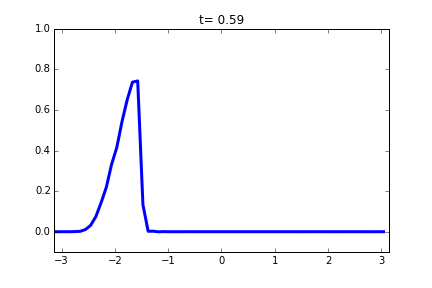
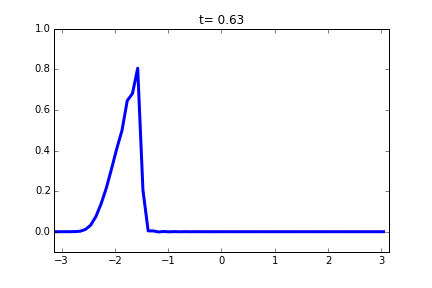
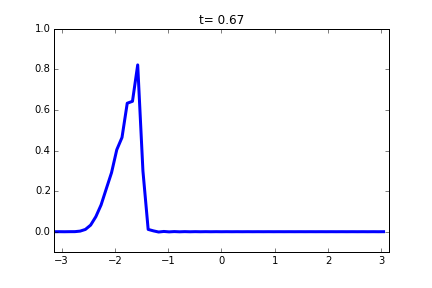
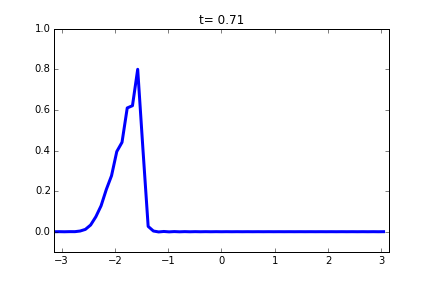
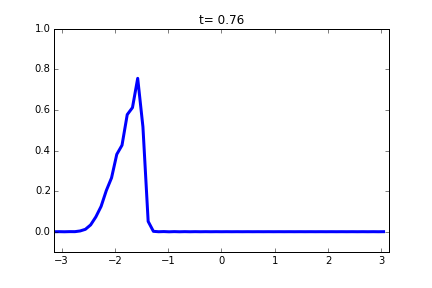
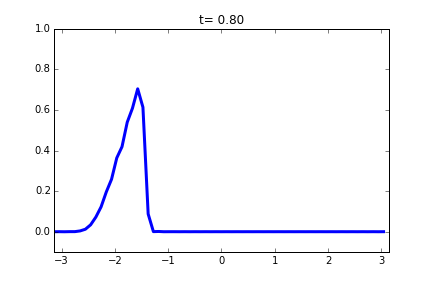
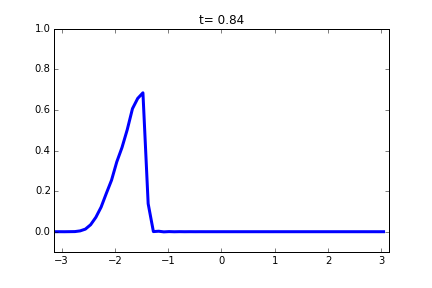
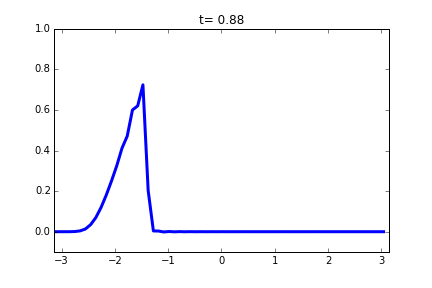
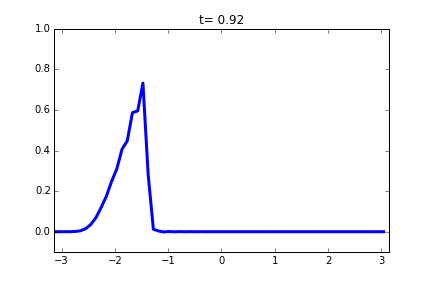
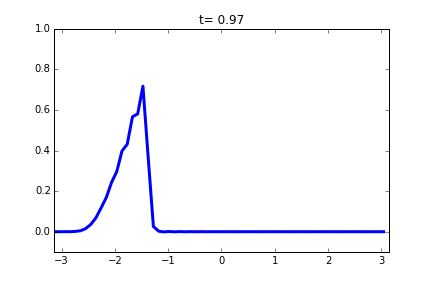
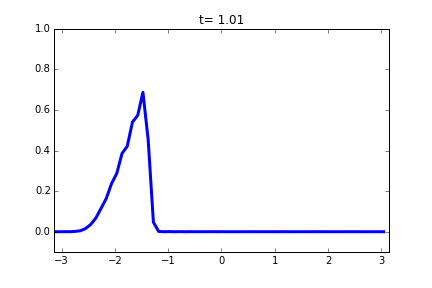
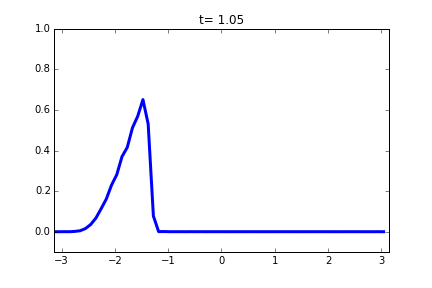
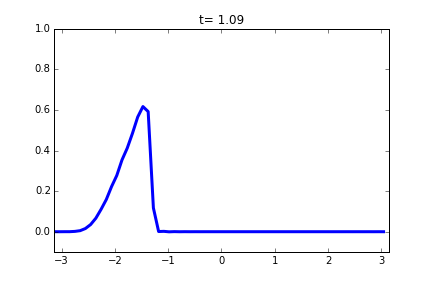
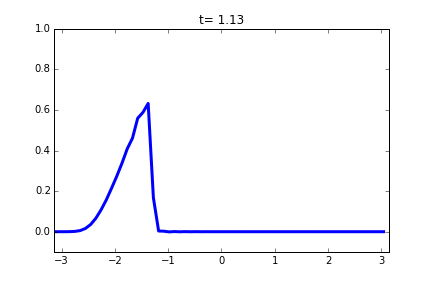
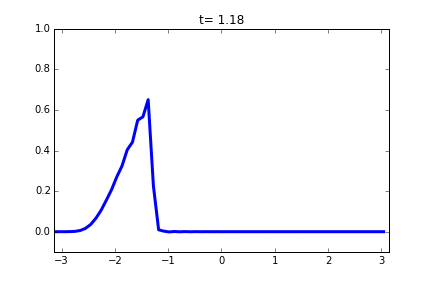
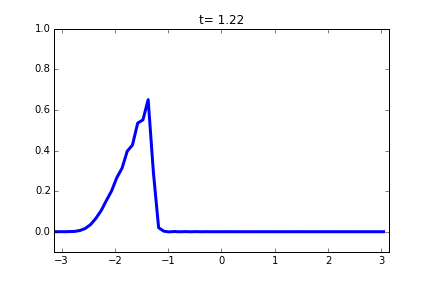
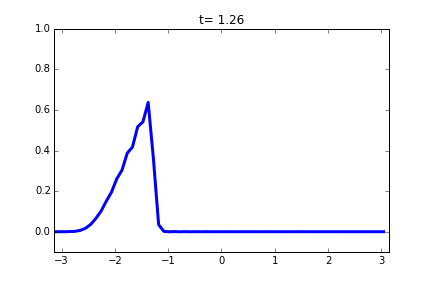
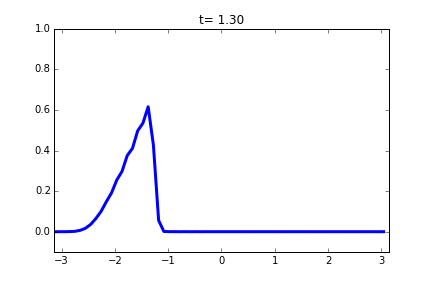
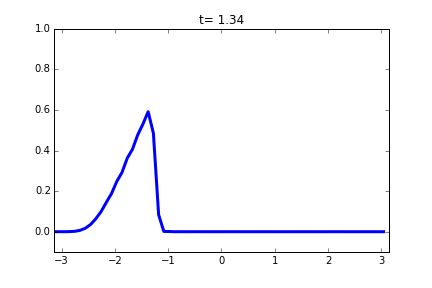
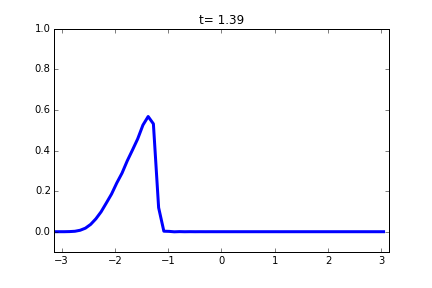
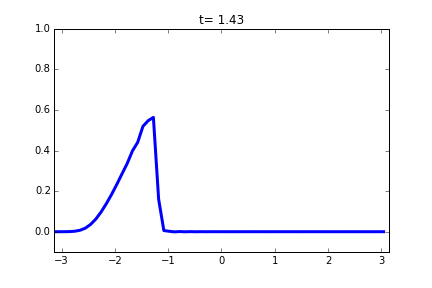
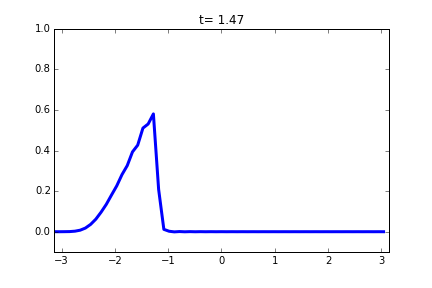
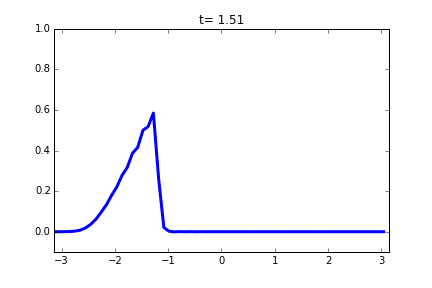
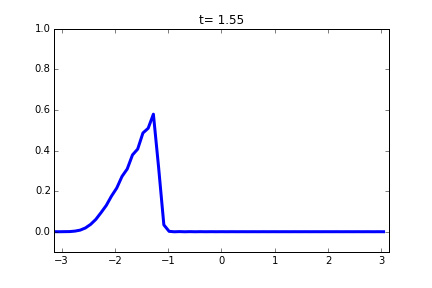
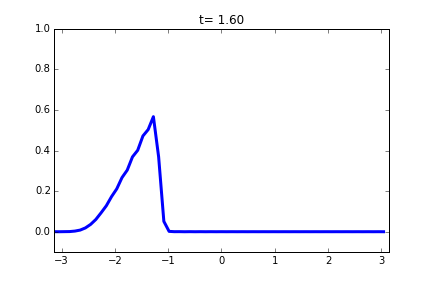
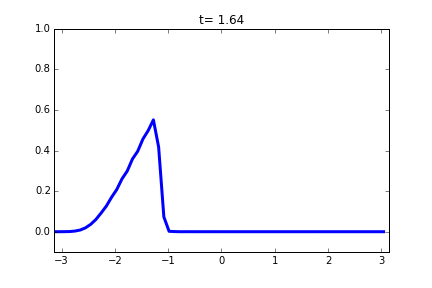
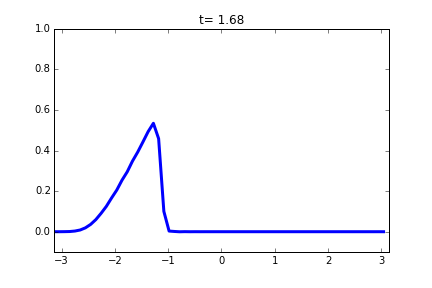
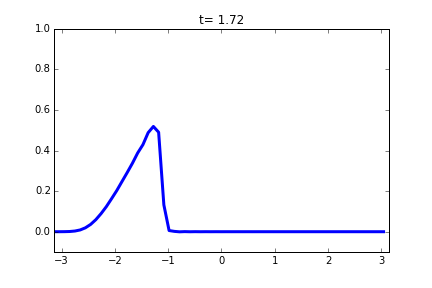
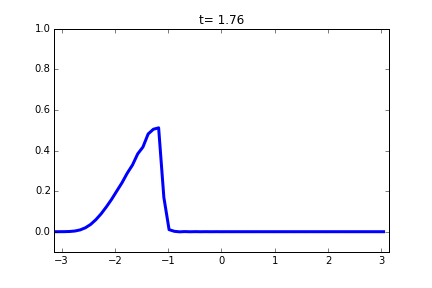
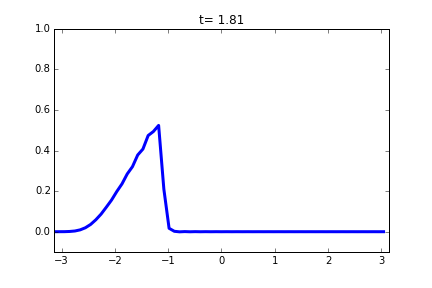
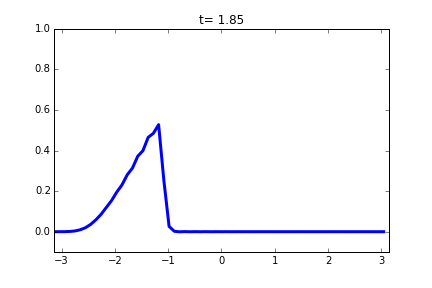
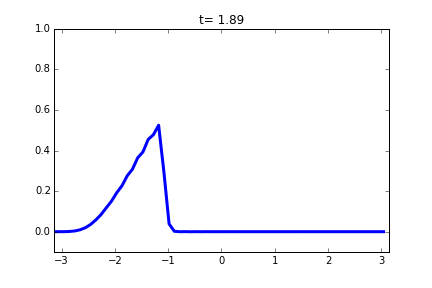
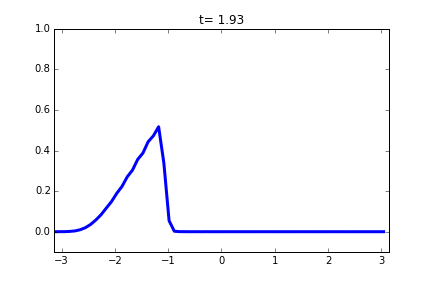
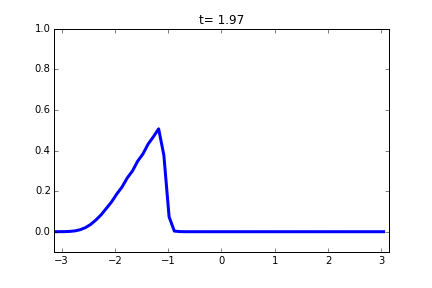
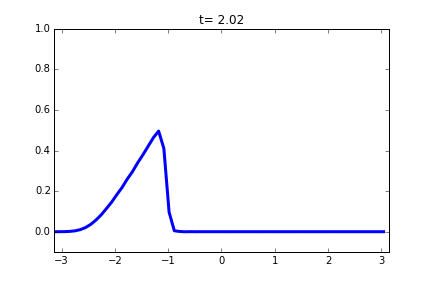
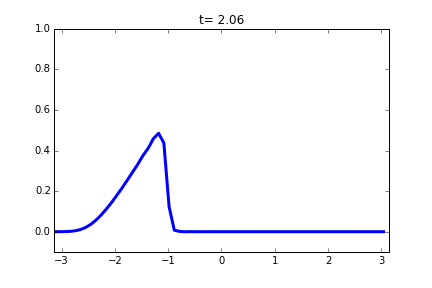
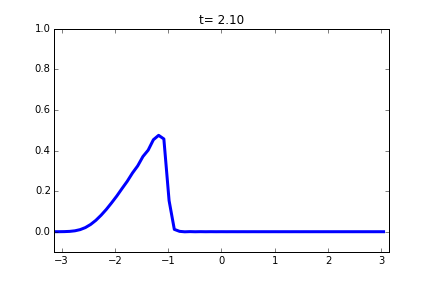

In [11]:
epsilon = 0.01

# Grid
m = 64
x = np.arange(-m/2,m/2)*(2*np.pi/m)
dx = x[1]-x[0]
L = x[-1]-x[0] + dx

dt = 1./(10*m**2)
tmax = 2.1

# Initial data
u = np.exp(-20*(x+2)**2)

# This is the order in which numpy's FFT gives the frequencies:
xi=np.fft.fftfreq(m)*m*2*np.pi/L

num_plots = 50
nplt = np.floor((tmax/num_plots)/dt)
nmax = int(round(tmax/dt))

fig = plt.figure()
axes = fig.add_subplot(111)
line, = axes.plot(x,u,lw=3)

frames = [u.copy()]
tt = [0]

for n in range(1,nmax+1):
    uhat = np.fft.fft(u)
    y2 = u + dt*(-u*np.real(np.fft.ifft(1j*xi*uhat)) + epsilon*np.real(np.fft.ifft(-xi**2*uhat)))
    uhat = np.fft.fft(y2)
    y3 = 0.75*u + 0.25*(y2 + dt*(-y2*np.real(np.fft.ifft(1j*xi*uhat)) + epsilon*np.real(np.fft.ifft(-xi**2*uhat))))
    uhat = np.fft.fft(y3)
    u_new = 1./3 * u + 2./3 * (y3 + dt*(-y3*np.real(np.fft.ifft(1j*xi*uhat)) + epsilon*np.real(np.fft.ifft(-xi**2*uhat))))

    u = u_new.copy()
    t = n*dt
    # Plotting
    if np.mod(n,nplt) == 0:
        frames.append(u.copy())
        tt.append(t)
        
def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t= %.2f' % tt[i])
    axes.set_xlim((-np.pi,np.pi))
    axes.set_ylim((-0.1,1.))
    
matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames), interval=20)

With the integrating factor method, we obtained the semi-discretization:

$$
\hat{U}'(t) = - \frac{i\xi}{2} \exp \left( \xi^2 \epsilon t \right)
    \mathcal F \left\{
        \left[
            \mathcal F^{-1} \left(
                \exp \left( -\xi^2 \epsilon t \right)\hat{U}
            \right)
        \right]^2
    \right\}.
$$

It should be obvious that the eigenvalues of the Jacobian of this RHS will be better behaved -- in particular, they will scale like $m$ rather than $m^2$.  That explains why we could take $\Delta t \propto 1/m$ with the integrating factor method.

# Splitting methods

In a way, our Burgers' discretization above is the worst of two worlds: we have to use time discretization because of the nonlinear term, and we have stiffness because of the linear term.  Wouldn't it be great if we could use time discretization for the nonlinear term only, while integrating the linear (stiff) term exactly?  Then we would be able to take time steps proportional to $1/m$ rather than $1/m^2$.  This approached is referred to as *operator splitting*.

To implement operator splitting, we alternate between solving

$$u_t = -u u_x$$
and
$$u_t = \epsilon u_{xx}.$$

For the first part, we can apply an ODE solver to the semi-discretization
$$U'(t) = - U \Finv \left(D\left[i\xi\right] \F(U)\right).$$

For the second part, we integrate exactly.


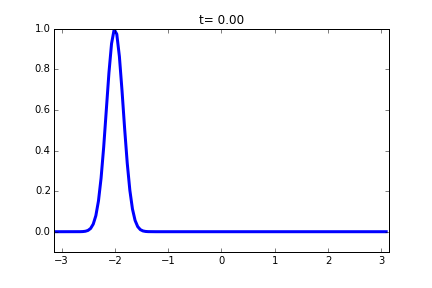
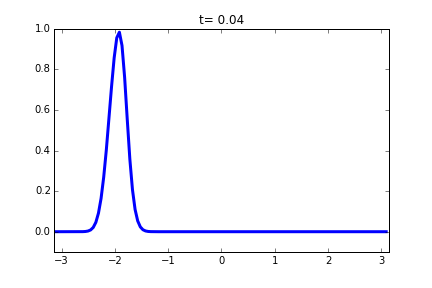
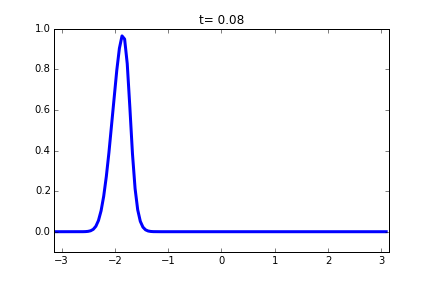
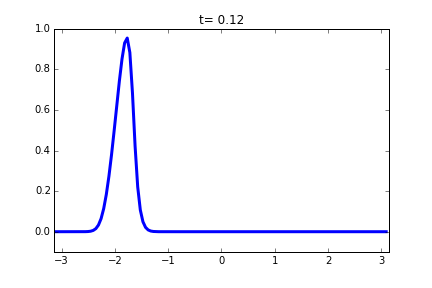
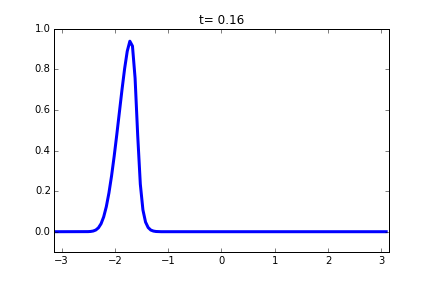
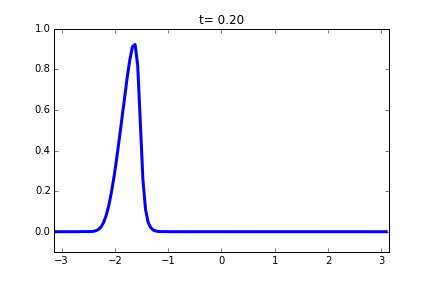
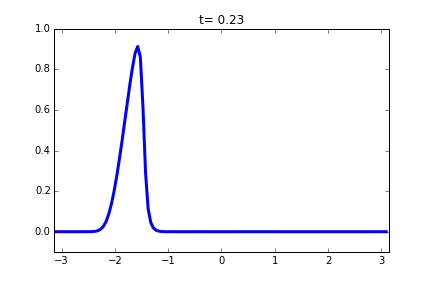
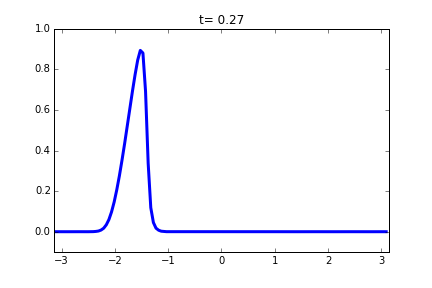
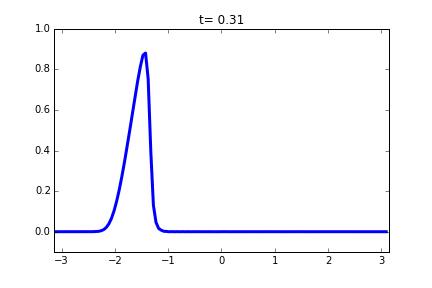
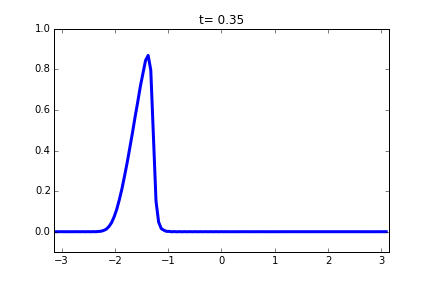
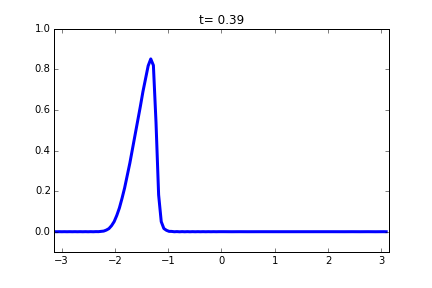
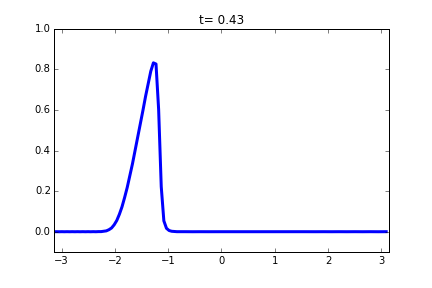
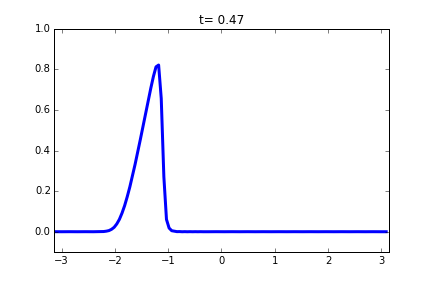
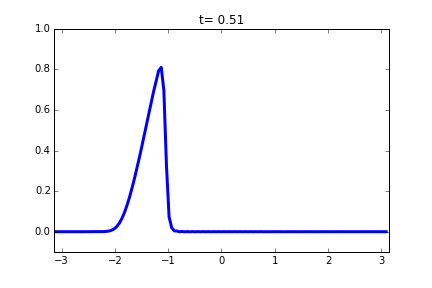
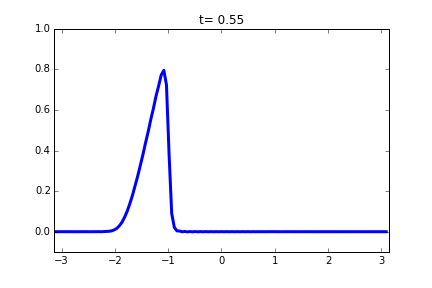
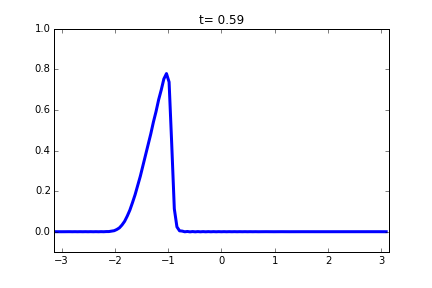
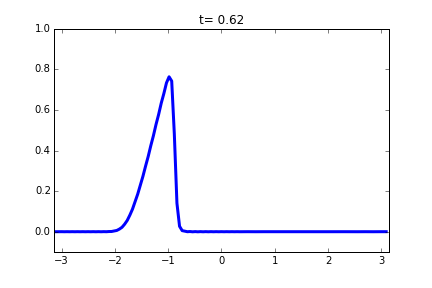
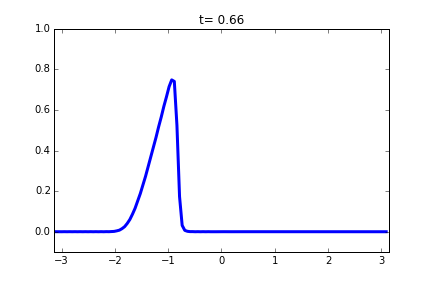
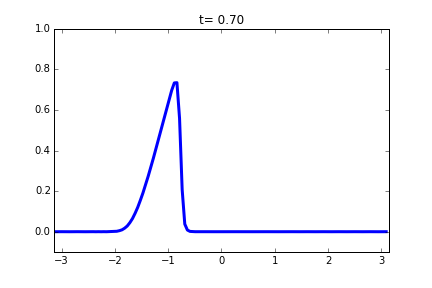
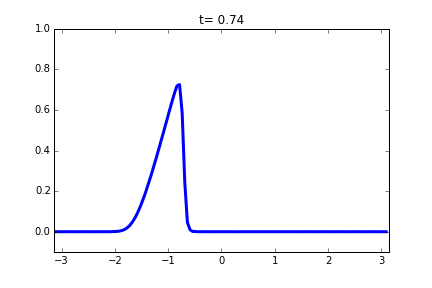
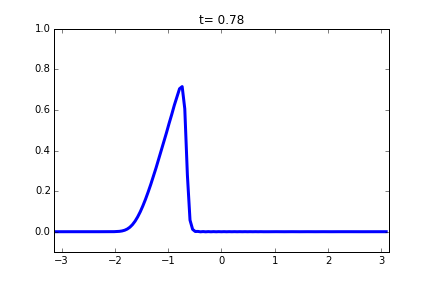
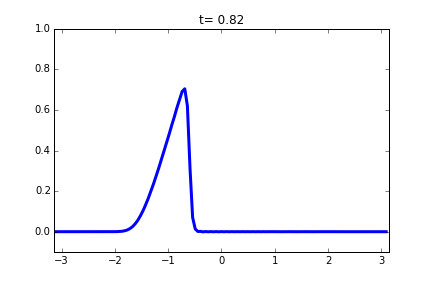
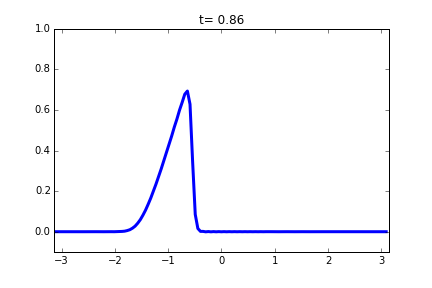
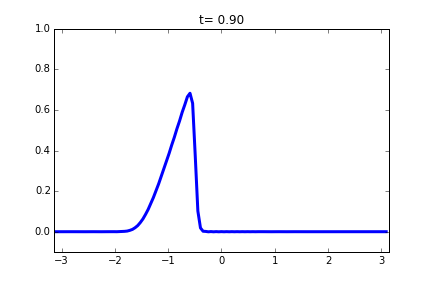
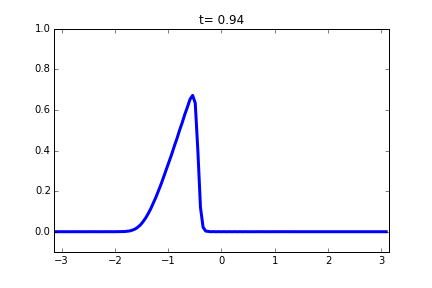
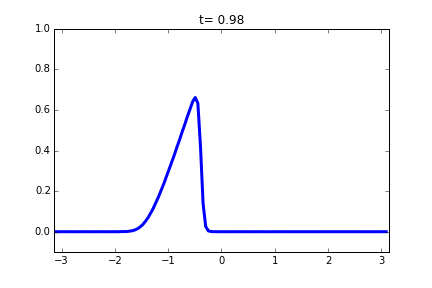
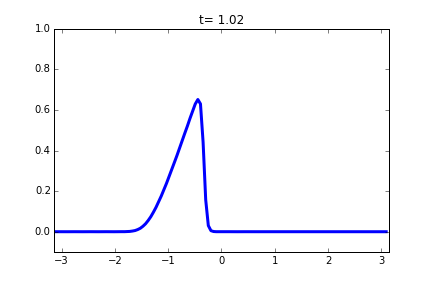
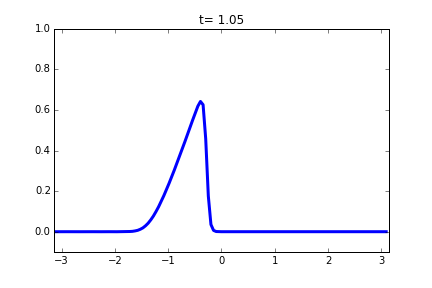
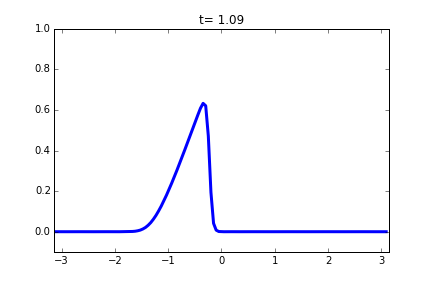
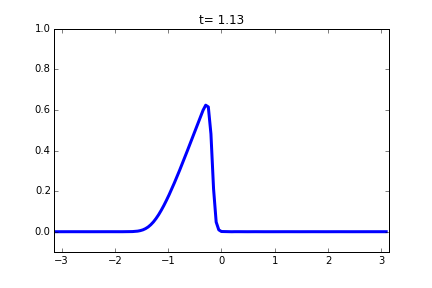
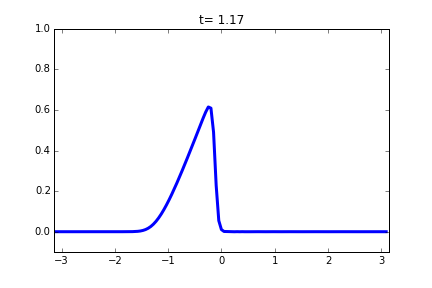
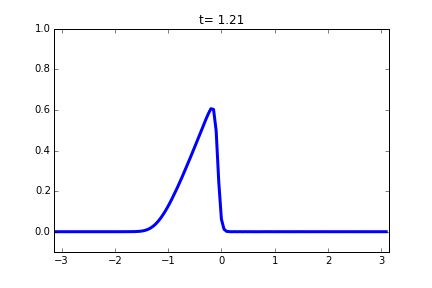
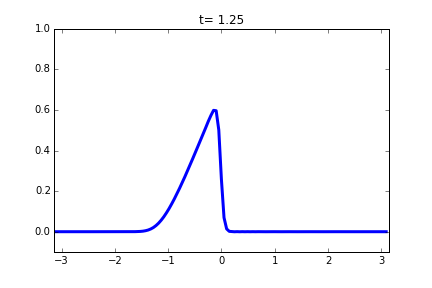
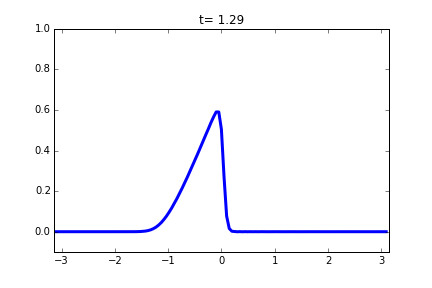
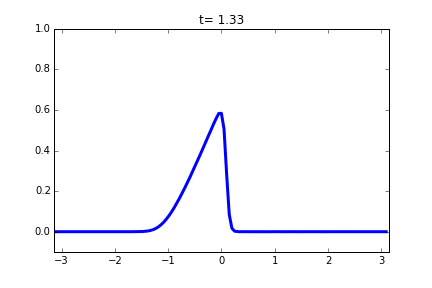
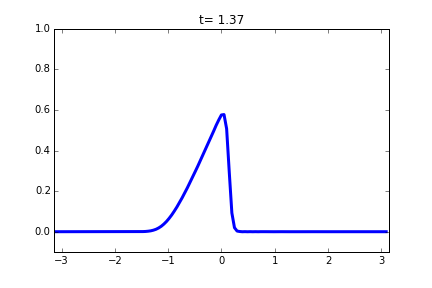
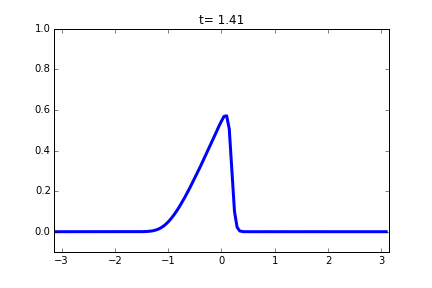
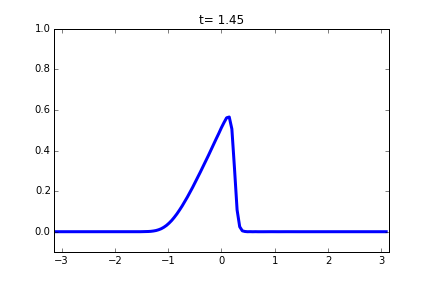
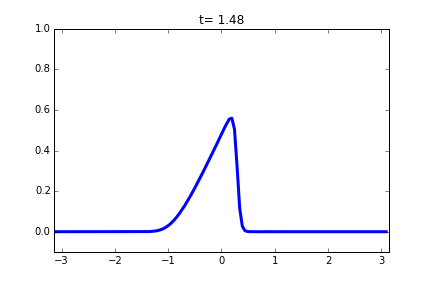
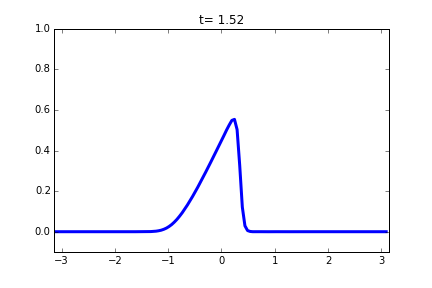
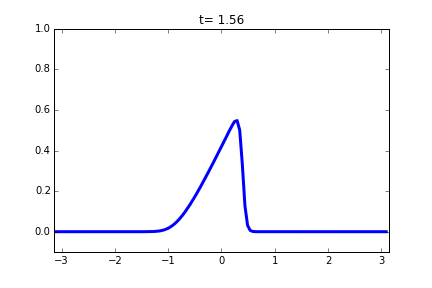
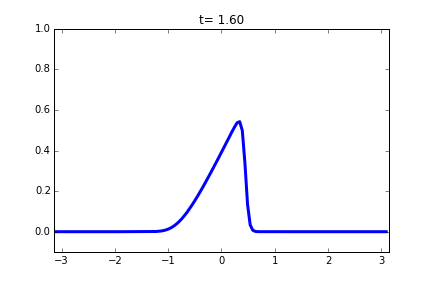
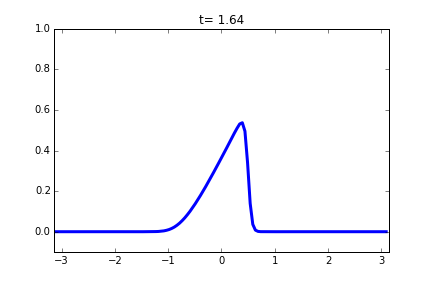
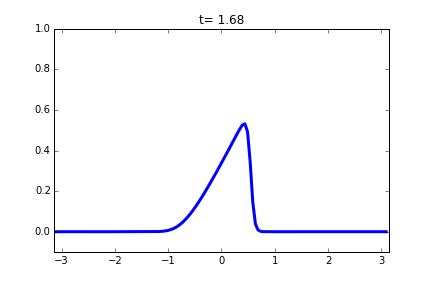
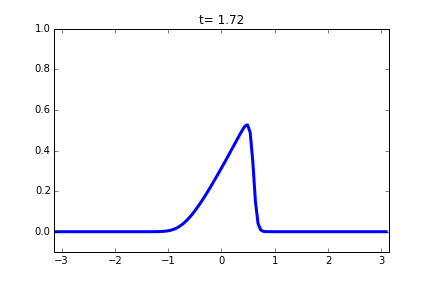
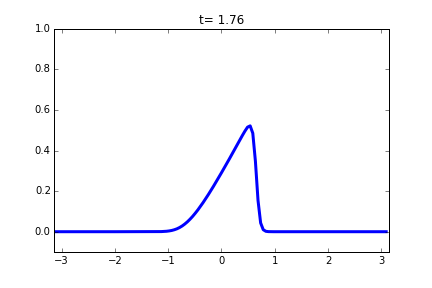
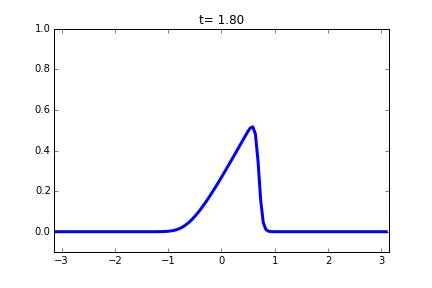
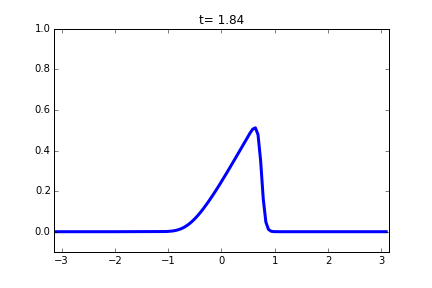
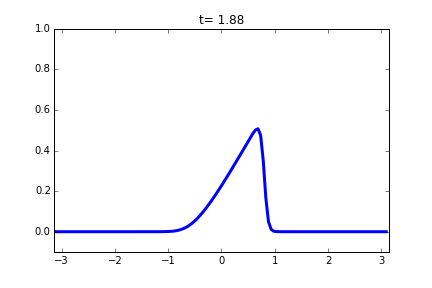
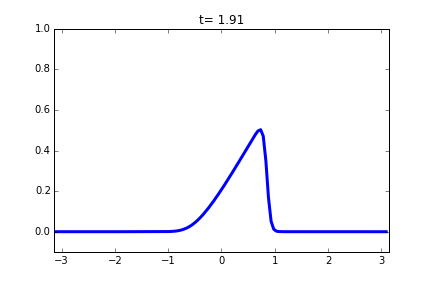
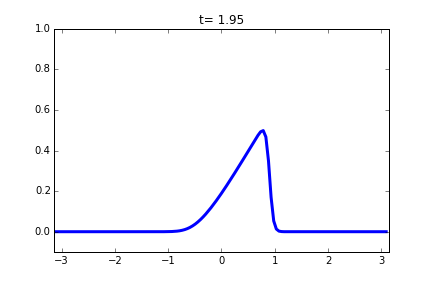
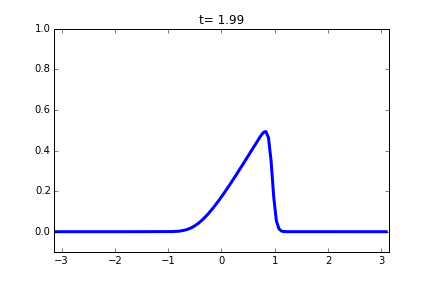
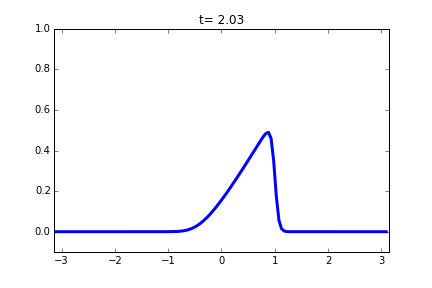
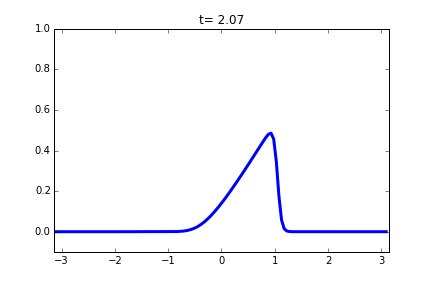

In [12]:
# Homework: implement the splitting approach here

epsilon = 0.01

# Grid
m = 128
x = np.arange(-m/2,m/2)*(2*np.pi/m)
dx = x[1]-x[0]
L = x[-1]-x[0] + dx

dt = 1./(m)
tmax = 2.1

# Initial data
u = np.exp(-20*(x+2)**2)

# This is the order in which numpy's FFT gives the frequencies:
xi=np.fft.fftfreq(m)*m*2*np.pi/L

num_plots = 50
nplt = np.floor((tmax/num_plots)/dt)
nmax = int(round(tmax/dt))

fig = plt.figure()
axes = fig.add_subplot(111)
line, = axes.plot(x,u,lw=3)

frames = [u.copy()]
tt = [0]

for n in range(1,nmax+1):
    
    # Explicit RK for nonlinear part:
    uhat = np.fft.fft(u)
    y2 = u + dt*(-u*np.real(np.fft.ifft(1j*xi*uhat)))
    uhat = np.fft.fft(y2)
    y3 = 0.75*u + 0.25*(y2 + dt*(-y2*np.real(np.fft.ifft(1j*xi*uhat))))
    uhat = np.fft.fft(y3)
    u_star = 1./3 * u + 2./3 * (y3 + dt*(-y3*np.real(np.fft.ifft(1j*xi*uhat))))
                                
    # Exact propagation for stiff part:
    uhat = np.exp(-(1.j*xi+epsilon*xi**2)*dt)*np.fft.fft(u_star)
    u_new = np.real(np.fft.ifft(uhat))
    
    u = u_new.copy()
    t = n*dt
    # Plotting
    if np.mod(n,nplt) == 0:
        frames.append(u.copy())
        tt.append(t)
        
def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t= %.2f' % tt[i])
    axes.set_xlim((-np.pi,np.pi))
    axes.set_ylim((-0.1,1.))
    
matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames), interval=20)